In [20]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import string
import binascii
import h5py
import numpy as np
import matplotlib.pyplot as plt
import numpy.matlib
import subprocess
import sca_training

%matplotlib inline

In [21]:
# Import all npy files
data_path = '../data/'
traces = np.load(data_path + 'traces_robin.npy')
ctexts = np.load(data_path + 'ctexts_robin.npy')
ptexts = np.load(data_path + 'ptexts_robin.npy')

# Print the imported data
print('Traces shape: ', traces.shape)
print('Ciphertexts shape: ', ctexts.shape)
print('Plaintexts shape: ', ptexts.shape)

Traces shape:  (300, 24400)
Ciphertexts shape:  (300, 16)
Plaintexts shape:  (300, 16)


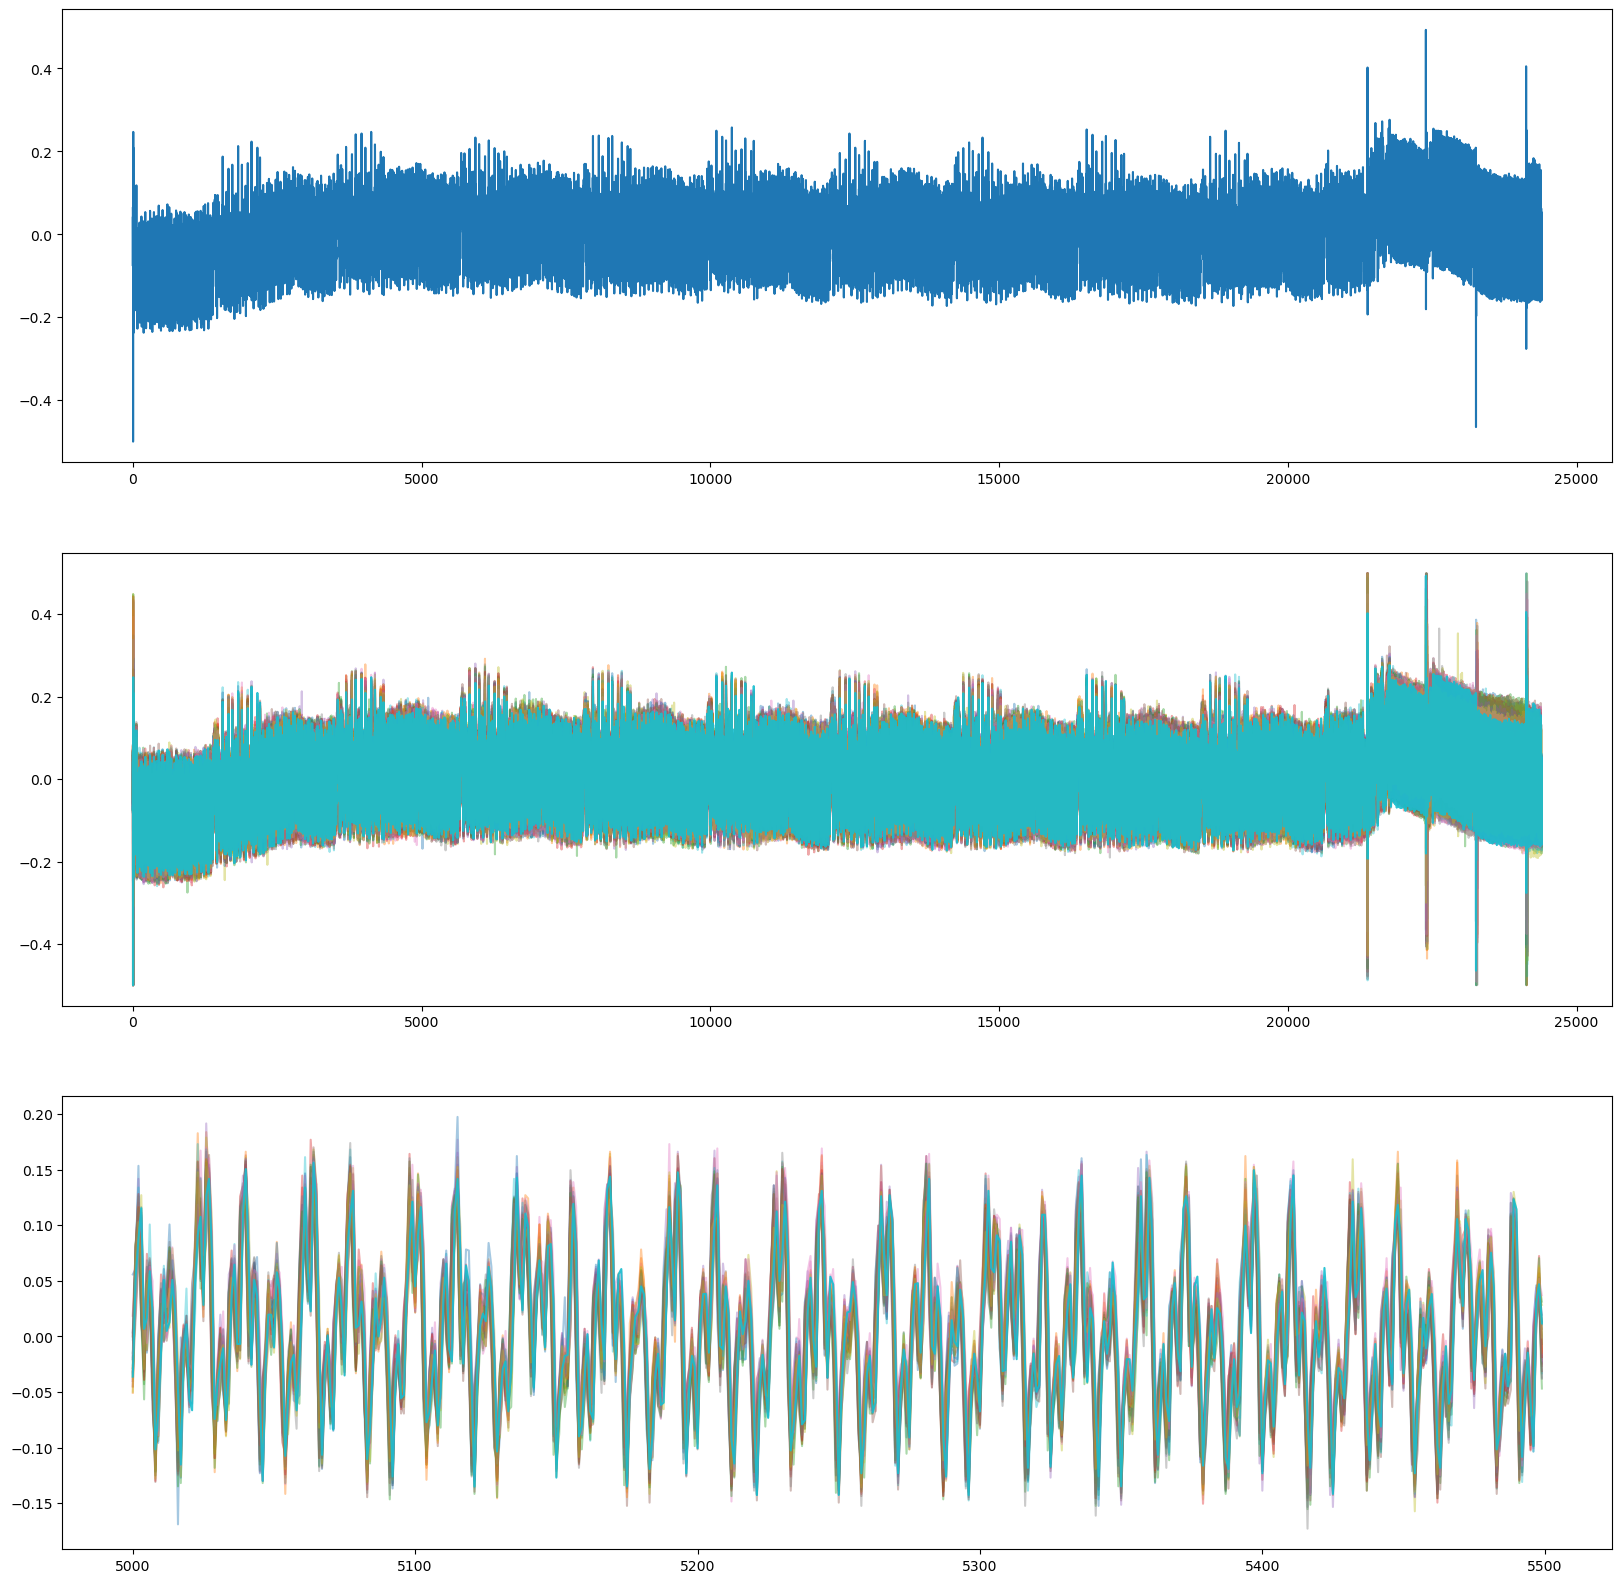

In [48]:
# Plot the first trace
fig, ax = plt.subplots(3,1, figsize=(20, 20))
ax[0].plot(traces[0])

y_range = np.arange(10, 300, 10)
# Plot some traces

for i in y_range:
    ax[1].plot(traces[i], alpha=0.4)
ax[1].plot(traces[0], alpha=0.9)

# Plot 500 samples from some traces
x_range = np.arange(5000, 5500)
for i in y_range:
    ax[2].plot(x_range, traces[i, x_range], alpha=0.4)
ax[2].plot(x_range, traces[0,x_range], alpha=0.9)

plt.show()


In [23]:
# Convert each texts into a 16 bytes array
# Used to convert our traces, not Robin's
# ctexts = np.array([ np.frombuffer(ctext, dtype=np.uint8, count=16) for ctext in ctexts ])
# ptexts = np.array([ np.frombuffer(ptext, dtype=np.uint8, count=16) for ptext in ptexts ])

In [24]:
# Find the traces with a variance smaller than 0.01
variances = np.var(traces, axis=1)
variances = variances < 0.01

traces = traces[variances]
ctexts = ctexts[variances]
ptexts = ptexts[variances]

In [25]:
NUM_SAMPLES = len(traces)

ptexts_columns = ptexts[:NUM_SAMPLES, :].T
ctexts_columns = ctexts[:NUM_SAMPLES, :].T
traces_columns = traces[:NUM_SAMPLES, 0:1500].T

print(ptexts_columns.shape)
print(ctexts_columns.shape)
print(traces_columns.shape)

(16, 300)
(16, 300)
(1500, 300)


In [26]:
from math import inf
k1 = np.array([(None, -inf)] * 16)

In [27]:
for slot, ptexts_column in enumerate(ptexts_columns):
    for kbyte in range(32, 128):
        guess = np.array([kbyte] * NUM_SAMPLES)
        guess = np.bitwise_xor(guess, ptexts_column)
        guess = sca_training.Sbox[guess]
        guess = sca_training.HW_uint8[guess]
        
        ccoef = np.max(np.absolute(np.corrcoef(guess, traces_columns)[0, 1:]))
        if ccoef > k1[slot, 1]:
            k1[slot] = (kbyte, ccoef)

    print(f'Slot {slot}: {k1[slot]}')

Slot 0: [72 0.6257716093024294]
Slot 1: [69 0.4195836093295368]
Slot 2: [73 0.5926876175463313]
Slot 3: [71 0.7117050489436413]
Slot 4: [123 0.4701577477259189]
Slot 5: [107 0.6541406941960517]
Slot 6: [49 0.48222389756565964]
Slot 7: [110 0.5735616812436973]
Slot 8: [100 0.6980827325775251]
Slot 9: [97 0.3972622882176474]
Slot 10: [78 0.5785608756434811]
Slot 11: [48 0.6610316397929622]
Slot 12: [105 0.5665512137572742]
Slot 13: [83 0.6428932418595086]
Slot 14: [121 0.493928656671732]
Slot 15: [125 0.47409173345299543]


In [28]:
binascii.unhexlify(''.join('{:02x}'.format(c) for c in k1[:, 0]))

b'HEIG{k1ndaN0iSy}'